# Find Your Employee

It takes a job query, finds the most similar resumes using embeddings, and visualizes them in 2D with PCA.

(note: demo is trained on synthetic data, not real resumes).

## Loader

In [32]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
df_resume = pd.read_csv('/content/resumes.csv')
df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"
df_resume.head()

/tmp/ipython-input-3436819315.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"


,resume,role
0,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
1,**Name:** John Smith\n\n**Summary:** Analytica...,Data Scientist
2,Generating a resume for a Data Scientist:\n\n-...,Data Scientist
3,# John Doe\n\n## Summary\nDynamic and results-...,Data Scientist
4,Creating a resume for a Data Scientist...\n\n-...,Data Scientist


In [4]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-v2")

# embed vectors
embedding_arr = model.encode(df_resume['resume'])
embedding_arr.shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(100, 384)

## Visualize Embeddings

In [5]:
# apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.20392154 0.1321688 ]


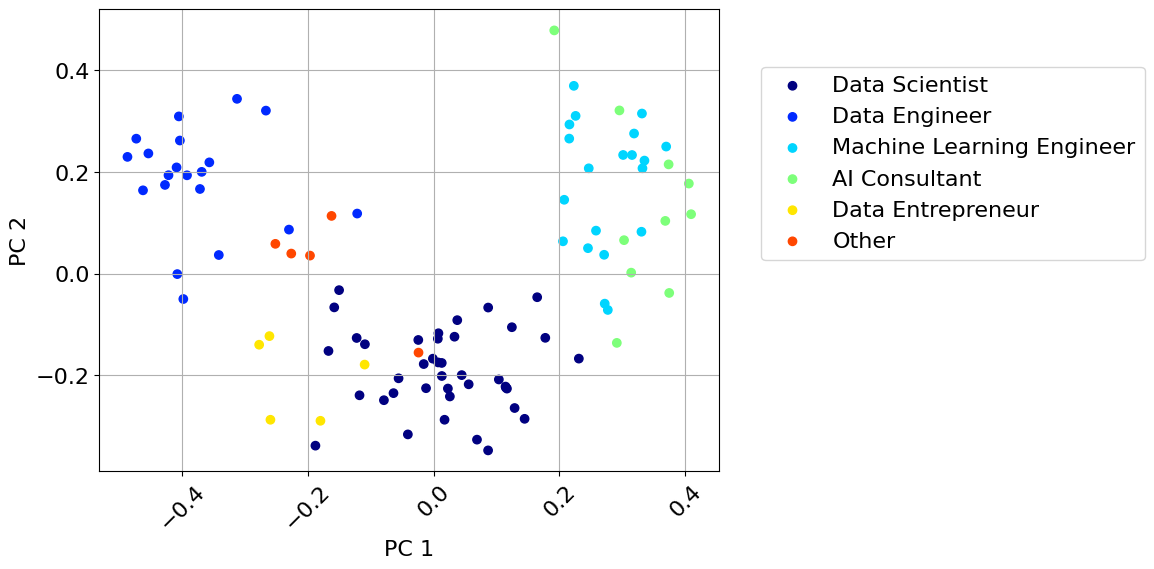

In [6]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Semantic Search [Try Out Yourself]


In [11]:
query = "I need someone to build out my data infrastructure"
# query = "Co-founder for marketing analytics consultancy"
# query = "Project manager for AI feature development"

# query = "Data Engineer with Apache Airflow experience"

In [12]:
# embed query
query_embedding = model.encode(query)

In [13]:
# define distance metric
dist = DistanceMetric.get_metric('euclidean') # other distances: manhattan, chebyshev

# compute pair wise distances between query embedding and all resume embeddings
dist_arr = dist.pairwise(embedding_arr, query_embedding.reshape(1, -1)).flatten()
# sort results
idist_arr_sorted = np.argsort(dist_arr)

In [14]:
# print roles of top 10 closest resumes to query in embedding space
print(df_resume['role'].iloc[idist_arr_sorted[:10]])

41        Data Engineer
40        Data Engineer
57        Data Engineer
54        Data Engineer
59        Data Engineer
42        Data Engineer
48        Data Engineer
55        Data Engineer
93    Data Entrepreneur
44        Data Engineer
Name: role, dtype: object


In [15]:
# print resume closest to query in embedding space
print(df_resume['resume'].iloc[idist_arr_sorted[0]])

**Name:** [John Doe]

**Summary:**
Experienced Data Engineer with a strong background in designing and implementing data infrastructure solutions. Skilled in developing ETL processes, creating data pipelines, and optimizing database performance. Proficient in SQL, Python, and cloud technologies.

**Professional Experience:**
- *Senior Data Engineer, TechSolutions Inc.*
  - Lead a team in designing and implementing a scalable data infrastructure that improved data processing efficiency by 30%.
  - Developed ETL processes to extract, transform, and load data into the data warehouse.
  - Optimized database performance by fine-tuning queries and implementing indexing strategies.

- *Data Engineer, DataWorks Corp.*
  - Built data pipelines using Apache Spark for real-time data processing.
  - Collaborated with data scientists to implement machine learning models into production systems.
  - Managed cloud-based storage solutions and ensured data security protocols were followed.

**Education

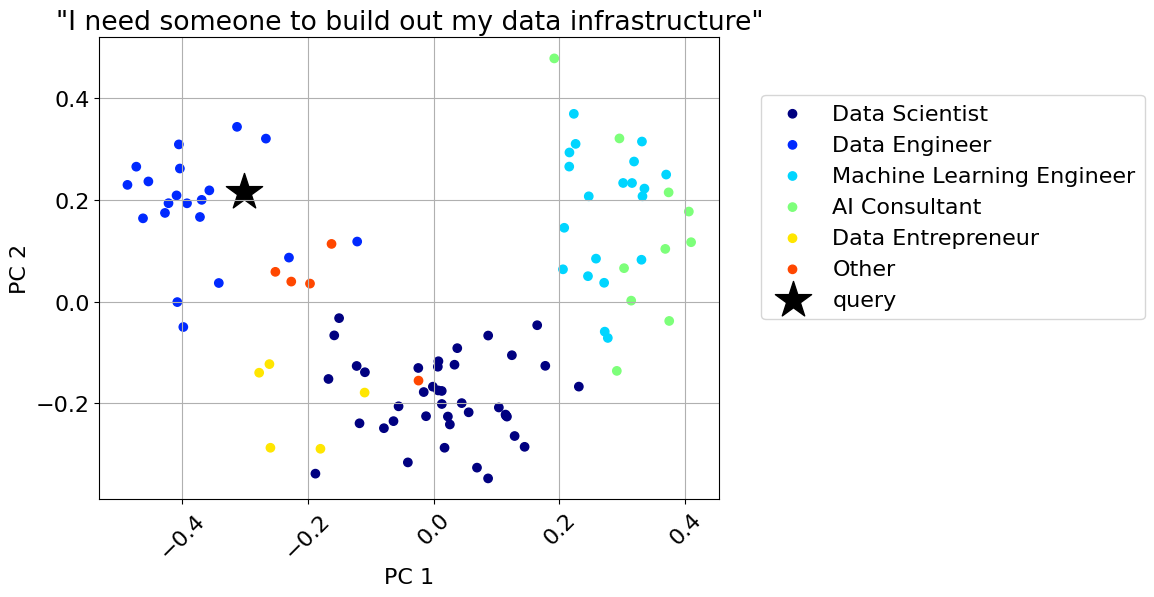

In [16]:
# plot query along with resumes using PCA components
query_pca = pca.transform(query_embedding.reshape(1, -1))[0]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.scatter(query_pca[0], query_pca[1], c='k', marker='*', s=750, label='query')

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('"' + query + '"')
plt.show()

In [ ]:
y